## Demo for project 1

In [88]:
import torch
import torchvision

### Define dataset and dataloader

In [89]:
%load_ext autoreload
%autoreload 2

from dataset import load_dataset

trainset, valset = load_dataset(train=True,is_vert_flip = False,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=False)
testset = load_dataset(train=False)

batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 100/100 [00:00<00:00, 33375.54it/s]


### Check dataset and dataloader

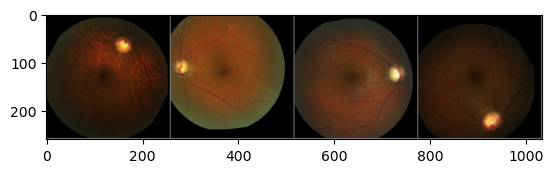

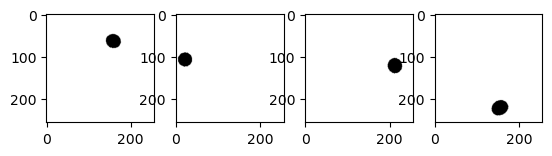

In [90]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # The data need to be normalized and unnormalized to keep the same
    # img = img / 255
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, targets = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print(names)
for i in range(batch_size):
    target = targets.numpy()[i,:,:]
    plt.subplot(1,batch_size,i+1)
    plt.imshow(target,cmap='gray')


### Q1: Domain generalization example.

In [91]:
from dataset import domain_generization, load_dataset
# trainset_temp, _ = load_dataset(train=True,is_vert_flip = True,is_rotate = True,is_translate = True,is_color_jitter = False,is_DG=False)
trainset_temp, _ = load_dataset(train=True,is_vert_flip = False,is_rotate = False,is_translate = False,is_color_jitter = False,is_DG=False)

100%|██████████| 100/100 [00:00<00:00, 25067.56it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


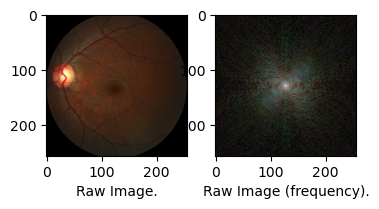

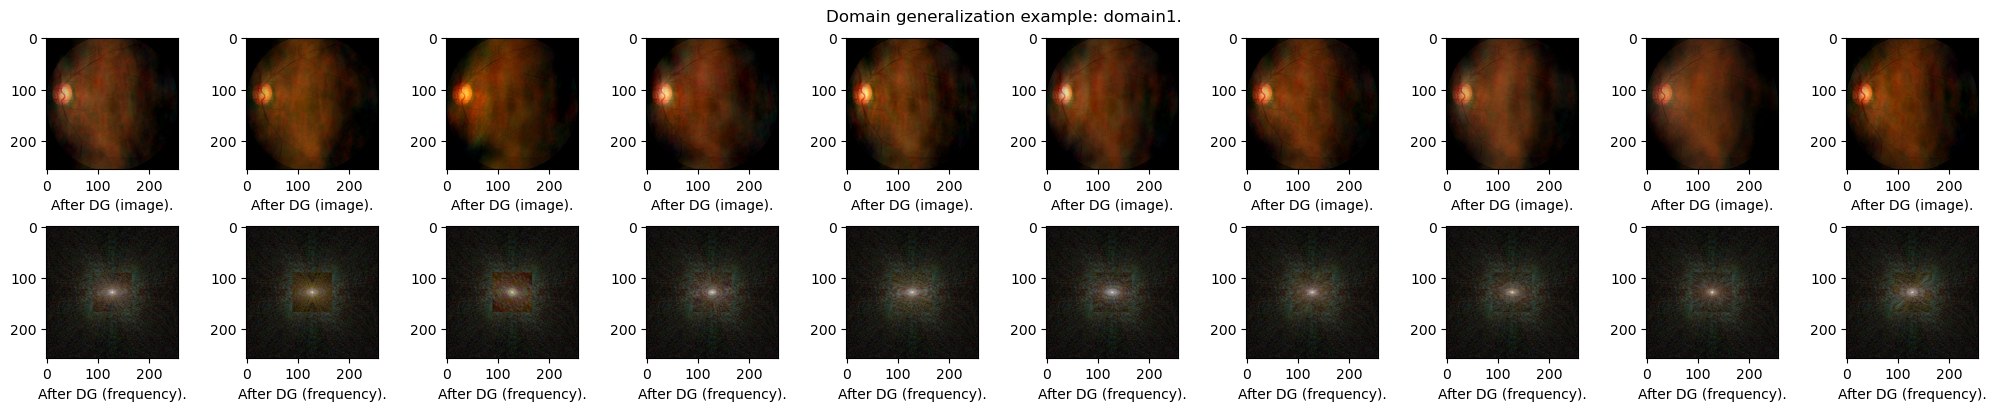

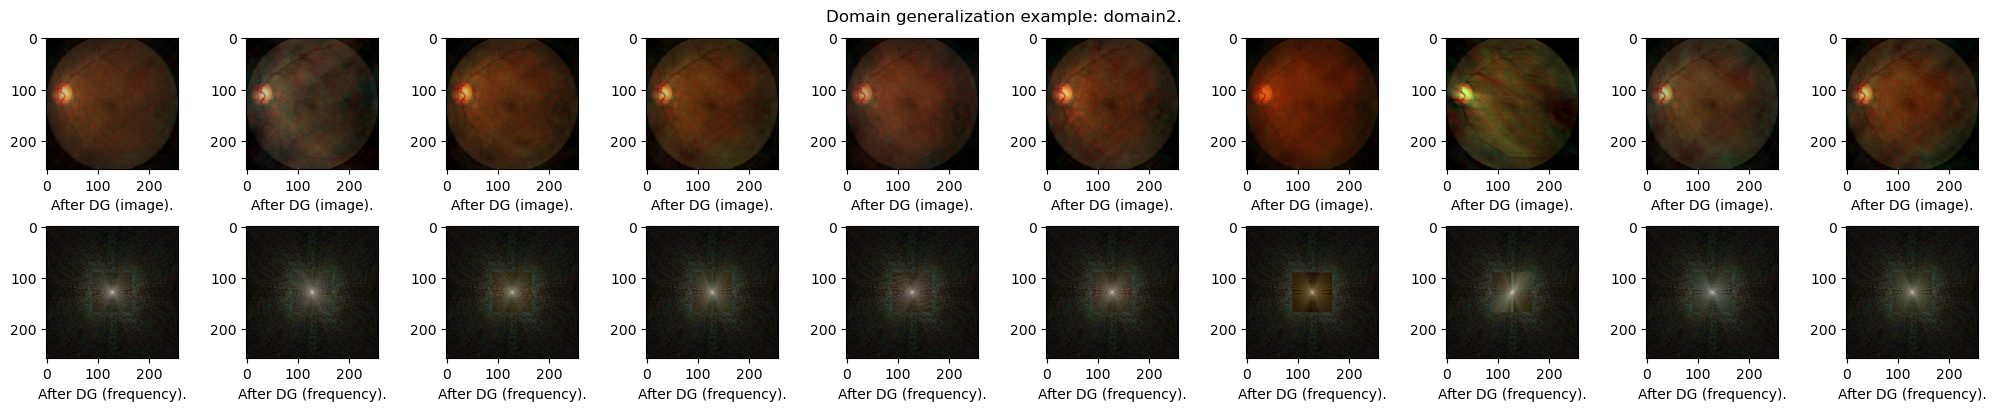

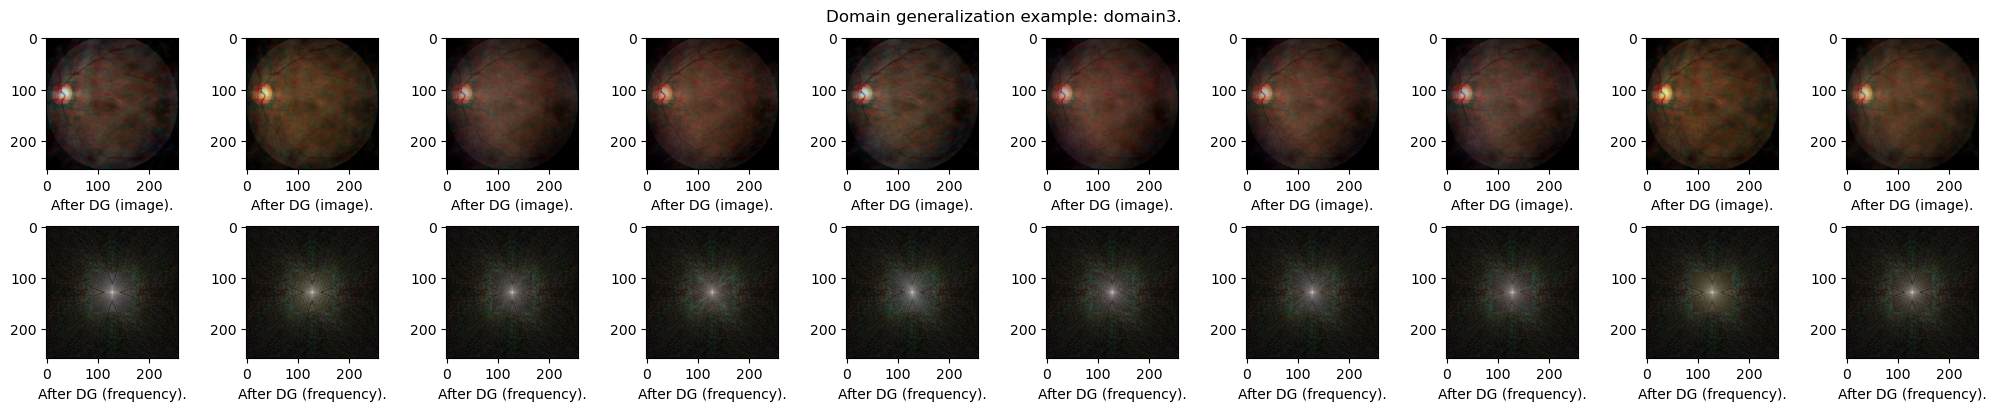

In [92]:
import matplotlib.pyplot as plt
import numpy as np
original_image, _ = trainset_temp.__getitem__(0) # Use the first image in training set.
original_image = original_image / 2 + 0.5
original_image = original_image.numpy()
scaling_factor = 0.3 # 替换低频区域所占大小
ratio = 1 #替换区域中目标域图片的幅度比重 
num_generalized=10
domains = ['domain1','domain2','domain3'] # 可选：'random'（默认随机选择domain）, 'domain1', 'domain2', 'domain3'.
original_image_freq = np.fft.fftshift(np.fft.fft2(original_image,axes=(-2,-1)),axes=(-2,-1))
original_image_freq = np.log(np.abs(original_image_freq))/np.max(np.log(np.abs(original_image_freq))) # log and normalize
plt.figure(figsize=[4,2])
plt.subplot(1,2,1), plt.imshow(np.transpose(original_image, (1, 2, 0))), plt.xlabel('Raw Image.')
plt.subplot(1,2,2), plt.imshow(np.transpose(original_image_freq, (1, 2, 0))), plt.xlabel('Raw Image (frequency).')
dg_outputs_domains = []
for domain in domains:
    dg_outputs, dg_fre_outputs= np.array(domain_generization(original_image,scaling_factor, ratio,num_generalized,domain)) # 输出是一个float, 因为计算傅里叶变换的时候应该用float提高精度
    dg_outputs = np.real(dg_outputs)
    fig, axs = plt.subplots(2, num_generalized, figsize=(2*num_generalized, 2*2), layout="constrained")
    for i in range(num_generalized):
        dg_output = dg_outputs[i]
        dg_fre_output = dg_fre_outputs[i]
        dg_fre_output = np.log(np.abs(dg_fre_output))/np.max(np.log(np.abs(dg_fre_output))) # log and normalize
        axs[0,i].imshow(np.clip(np.transpose(dg_output, (1, 2, 0)),0,1)) # 转回int才可以直接imshow
        axs[0,i].set_xlabel('After DG (image).')
        axs[1,i].imshow(np.clip(np.transpose(dg_fre_output,(1,2,0)),0,1),cmap='gray')
        axs[1,i].set_xlabel('After DG (frequency).')
    plt.suptitle('Domain generalization example: {}.'.format(domain))
    dg_outputs_domains.append(dg_outputs)

Distances between 3 domains:
[[14.50710514 31.4325628  35.07297641]
 [31.4325628  15.97145984 20.06473543]
 [35.07297641 20.06473543 10.53362501]]


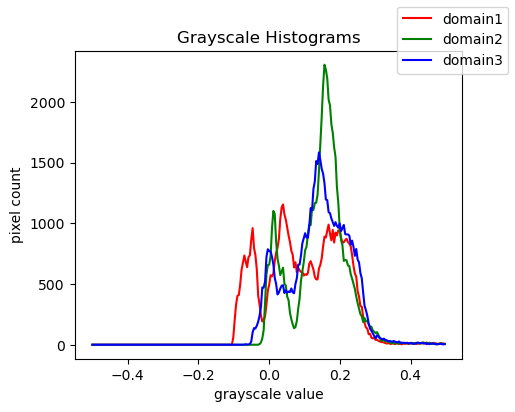

In [93]:
from dis_rep import norm_dist,CS_dist,intra_cluster_distance,inter_cluster_diatance
D = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        if i == j:
            D[i,j] = intra_cluster_distance(dg_outputs_domains[i],distance_metric=norm_dist,ord=None)
        else:
            D[i,j] = inter_cluster_diatance(dg_outputs_domains[i],dg_outputs_domains[j],distance_type=2,distance_metric=norm_dist,ord=None)[0]
print('Distances between 3 domains:')
print(D)
def rgb2gray(rgb):
    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:] # PIL读到图片是RGB顺序
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
domain1_gray_average = np.mean(rgb2gray(dg_outputs_domains[0]),axis=0)
domain2_gray_average = np.mean(rgb2gray(dg_outputs_domains[1]),axis=0)
domain3_gray_average = np.mean(rgb2gray(dg_outputs_domains[2]),axis=0)
histogram1, bin_edges1 = np.histogram(domain1_gray_average, bins=256, range=(-0.5, 0.5))
histogram2, bin_edges2 = np.histogram(domain2_gray_average, bins=256, range=(-0.5, 0.5))
histogram3, bin_edges3 = np.histogram(domain3_gray_average, bins=256, range=(-0.5, 0.5))
plt.figure(figsize=(5,4))
plt.title("Grayscale Histograms")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.plot(bin_edges1[0:-1], histogram1,'r', bin_edges2[0:-1], histogram2, 'g', bin_edges3[0:-1], histogram3, 'b')
plt.figlegend(["domain1","domain2","domain3"],loc='upper right')

### Define a model

In [94]:
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)
# print(net)

### Define loss function and optimizer

In [95]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train network

In [96]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs, target) in enumerate(trainloader):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimizeo 
        # change the data to float type
        outputs = net(inputs)
        # outputs = torch.argmax(outputs, dim=1)
        # print((outputs.shape))
        # print(target.to(torch.float32).dtype)
        
        loss = criterion(outputs,target.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
            running_loss = 0.0

print('Finished Training')



[1,    20] loss: 0.488
[2,    20] loss: 0.079
[3,    20] loss: 0.039
[4,    20] loss: 0.028
[5,    20] loss: 0.022
[6,    20] loss: 0.018
[7,    20] loss: 0.016
[8,    20] loss: 0.013
[9,    20] loss: 0.012
[10,    20] loss: 0.011
[11,    20] loss: 0.010
[12,    20] loss: 0.009
[13,    20] loss: 0.008
[14,    20] loss: 0.008
[15,    20] loss: 0.007
[16,    20] loss: 0.007
[17,    20] loss: 0.006
[18,    20] loss: 0.006
[19,    20] loss: 0.006
[20,    20] loss: 0.005
Finished Training


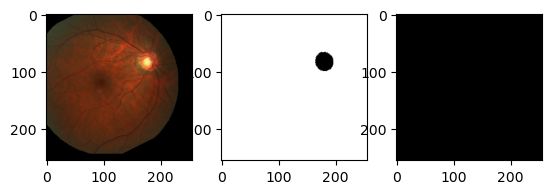

In [97]:
# show last training result
import matplotlib.pyplot as plt
import numpy as np

input = inputs.numpy()[-1]
input = input/2 + 0.5
output_np = torch.argmax(outputs[-1], dim=0).cpu().numpy()

plt.subplot(1,3,1)
plt.imshow(np.transpose(input,(1,2,0)))
plt.subplot(1,3,2)
plt.imshow(target[-1,:,:],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(output_np,cmap='gray')
plt.show()

### Save model

In [98]:
PATH = './net.pth'
torch.save(net.state_dict(), PATH)

### Test your model performance

In [99]:
from sklearn.metrics import accuracy_score, f1_score

nclasses = 2

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=nclasses,                      # model output channels (number of classes in your dataset)
)


net.load_state_dict(torch.load(PATH,map_location='cpu'))
dscs = []

with torch.no_grad():
    for data in testloader:
        images, targets, names = data
        
        outputs = net(images.to(torch.float32))
        
        for idx, name in enumerate(names):
            output_np = torch.argmax(outputs[idx], dim=0).cpu().numpy()
            binary_output = np.array(output_np)
            target_np = targets[idx].cpu().numpy().astype(np.uint8)
            
            target_1d = np.reshape(target_np, (-1, 1))
            pred_1d = np.reshape(binary_output, (-1, 1))
            accuracy = accuracy_score(target_1d, pred_1d)
            if nclasses == 2:
                dsc = f1_score(target_1d, pred_1d) # f1_score就是Dice
            else:
                dsc = f1_score(target_1d, pred_1d,average='micro')
            dscs.append(dsc) 

dsc_test = np.mean(dscs)
print('Dsc of test set:', dsc_test)

Dsc of test set: 0.0


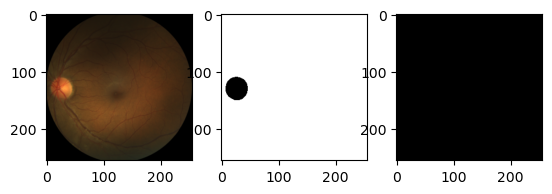

In [100]:
# show last predicted result
import matplotlib.pyplot as plt
image = images.numpy()[-1]
output = outputs.numpy()[-1,:,:,:]
image = image/2 + 0.5
plt.subplot(1,3,1)
plt.imshow(np.transpose(image,(1,2,0)))
plt.subplot(1,3,2)
plt.imshow(target_np,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(binary_output,cmap='gray')
plt.show()